In [1]:
# PyTorch Imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Module
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Normal

# Basic Python Imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Module Imports
from Modules.BayesLinear import BayesLinear
from Modules.Loss import BKLLoss
# from Modules.BayesHarry import BayesLinear as BayesHarry

import random
from sklearn.preprocessing import StandardScaler

random.seed(10)

import time

### Loss Functions

In [2]:
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
kl_loss = BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

### Load data
Format for Bayesian NN. Visualisation of the time series.

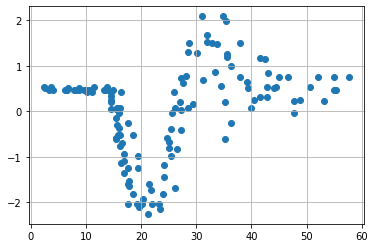

X : torch.Size([133, 1]) Y : torch.Size([133, 1, 1])


In [3]:
# Load data
data = pd.read_csv('Data/motorcycle.csv')

# Conversion to float tensors 
x = np.array(data['times'])
y = np.array(data['accel'])

#y = StandardScaler().fit_transform(y.reshape(-1,1))
x = torch.unsqueeze(torch.from_numpy(x), dim=1)
#y = torch.from_numpy(y)

y = StandardScaler().fit_transform(y.reshape(-1,1))
y = torch.unsqueeze(torch.from_numpy(y), dim=1)

x = x.float()
y = y.float()

x_np = x.squeeze().numpy()
y_np = y.squeeze().numpy()

# Plotting the timeseries
plt.figure()
plt.scatter(x, y)
plt.grid()
plt.show()

print('X :', x.shape, 'Y :', y.shape)

### Genetate Additional Data
#### Additional Training 

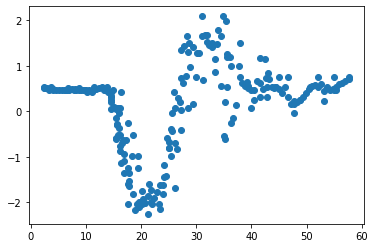

In [4]:
gp_mean = [0.5107,0.5032, 0.4939, 0.4843, 0.4765, 0.4718, 0.4713, 0.4748, 0.4805, 0.4856,
0.4870, 0.4824, 0.4724, 0.4604, 0.4523, 0.4543, 0.4695, 0.4953, 0.5216, 0.5319,
0.5067, 0.4284, 0.2868, 0.0825, -0.1722, -0.4559, -0.7433, -1.0112, -1.2435, -1.4339,
-1.5851, -1.7049, -1.8015, -1.8788, -1.9333, -1.9549, -1.9298, -1.8453, -1.6947, -1.4804,
-1.2140, -0.9140, -0.6013, -0.2950, -0.0080, 0.2536, 0.4900, 0.7046, 0.9006, 1.0778,
1.2317, 1.3542, 1.4362, 1.4710, 1.4573, 1.4012, 1.3147, 1.2139, 1.1143, 1.0277,
0.9589, 0.9056, 0.8605, 0.8146, 0.7605, 0.6959, 0.6241, 0.5533, 0.4935, 0.4538,
0.4395, 0.4501, 0.4795, 0.5173, 0.5507, 0.5678, 0.5600, 0.5241, 0.4632, 0.3869,
0.3092, 0.2456, 0.2098, 0.2103, 0.2482, 0.3164, 0.4015, 0.4868, 0.5568, 0.6006,
0.6147, 0.6033, 0.5769, 0.5487, 0.5311, 0.5324, 0.5549, 0.5950, 0.6441, 0.6919,
0.7285]

gp_stddev = [0.0477, 0.0400, 0.0463, 0.0514, 0.0529, 0.0502, 0.0438, 0.0366, 0.0330,0.0328, 0.0327,
0.0318, 0.0315, 0.0331, 0.0363, 0.0433, 0.0560, 0.0702, 0.0780, 0.0733, 0.0615, 0.0799,
0.1468, 0.2393, 0.3408, 0.4382, 0.5196, 0.5747, 0.5959, 0.5800, 0.5295, 0.4540, 0.3712,
0.3067, 0.2822, 0.2915, 0.3074, 0.3135, 0.3156, 0.3360, 0.3899, 0.4658, 0.5385, 0.5873,
0.6045, 0.5975, 0.5860, 0.5901, 0.6133, 0.6377, 0.6380, 0.5951, 0.5022, 0.3669, 0.2227,
0.1980, 0.3483, 0.5319, 0.6956, 0.8186, 0.8886, 0.8987, 0.8470, 0.7373, 0.5789, 0.3876,
0.1898, 0.1067, 0.2472, 0.3799, 0.4620, 0.4847, 0.4492, 0.3643, 0.2463, 0.1253, 0.1068,
0.2006, 0.2817, 0.3230, 0.3195, 0.2769, 0.2092, 0.1377, 0.0911, 0.0856, 0.0919, 0.0940,
0.1116, 0.1568, 0.2117, 0.2548, 0.2730, 0.2623, 0.2282, 0.1857, 0.1545, 0.1445, 0.1445,
0.1437, 0.1542]

y_sample = []

x_sample = np.linspace(min(x_np), max(x_np), len(gp_mean))

y_sample = [np.random.normal(gp_mean[i], gp_stddev[i]**2, 1) for i in range(len(gp_mean))]
    

x_new = np.append(x_np, x_sample)
y_new = np.append(y_np, y_sample)

plt.scatter(x_new, y_new)
plt.show()

idx = np.argsort(x_new)
x_sorted = x_new[idx]
y_sorted = y_new[idx]

x = torch.unsqueeze(torch.from_numpy(x_sorted), dim=1)
y = torch.unsqueeze(torch.from_numpy(y_sorted), dim=1)

x = x.float()
y = y.float()

#### Generate Test Dataset

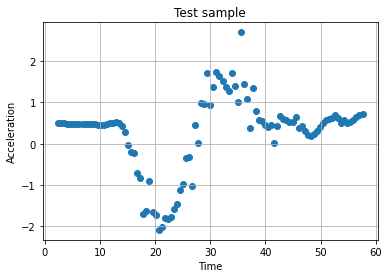

In [5]:
# create test data
x_test = np.linspace(min(x_np), max(x_np), len(gp_mean))
y_test = np.array([np.random.normal(gp_mean[i], gp_stddev[i]**2, 1) for i in range(len(gp_mean))])

plt.scatter(x_test, y_test)
#plt.scatter(x, y)
plt.grid()
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Test sample')
plt.show()

x_test = torch.unsqueeze(torch.from_numpy(x_test), dim=1)
y_test = torch.unsqueeze(torch.from_numpy(y_test), dim=1)

x_test = x_test.float()
y_test = y_test.float()

### BNN - With Aleatoric Uncertainty

In [6]:
class Net(Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_feature, out_features=n_hidden, bias=True)   # hidden layer
        self.hidden2 = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_hidden, bias=True)
        self.predict = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_output, bias=True)   # output layer
        
    def forward(self, x):
        x = torch.tanh(self.hidden1(x))      # activation function for hidden layer
        x = torch.tanh(self.hidden2(x))
        x = self.predict(x)              # linear output
        
        mu, log_std = x.chunk(2, dim=1)
        
        dist = Normal(mu, torch.exp(log_std))

        return dist
    
net_BNN_aleatoric = Net(n_feature=1, n_hidden=50, n_output=2)     # define the network
print(net_BNN_aleatoric)  # net architecture

Net(
  (hidden1): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=50, bias=True)
  (hidden2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=50, out_features=50, bias=True)
  (predict): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=50, out_features=2, bias=True)
)


In [7]:
# net = net.float()

# optimizer = optim.Adam(net.parameters(),  lr=0.001)

# kl_loss = BKLLoss(reduction='mean', last_layer_only=False)
#kl_weight = 0.01

#mse_loss = nn.MSELoss()

#for t in range(50000):
    
#    optimizer.zero_grad()
    
    #mean, log_var = net(x)
#    distribution = net(x.float())
    
#    kl = kl_loss(net)
    
    #mse = mse_loss(prediction[:,0], y.float().squeeze())
    #distribution = Normal(mean, var)
    
    #nll = -1/2 * torch.log(2*math.pi*var) - (y.float()-mean)**2 / (2*var)
    #cost = -nll.sum() + kl_weight*kl
    #cost = -distribution.log_prob(y.float()).sum() #+ kl_weight*kl
#    loss = -distribution.log_prob(y.float()).sum(1).mean() + kl_weight*kl
    
#    loss.backward()
    
#    optimizer.step()
    
#print('- MSE : %2.2f, KL : %2.2f' % (loss.item(), kl.item()))

Implement mini-batches to speed up training process.

In [9]:
start_time = time.time()

from torch.utils.data import DataLoader, TensorDataset
n_epochs = 6000 # or whatever
batch_size = 32 # or whatever

train_loader = DataLoader(TensorDataset(x, y), batch_size=batch_size, shuffle=True)

net_BNN_aleatoric = net_BNN_aleatoric.float()

optimizer = optim.Adam(net_BNN_aleatoric.parameters(),  lr=0.001)

for epoch in range(n_epochs):

    # Run batch
    for x_train, y_train in train_loader:
        optimizer.zero_grad()

        # in case you wanted a semi-full example
        distribution = net_BNN_aleatoric(x)
        kl = kl_loss(net_BNN_aleatoric)
        
        loss = -distribution.log_prob(y.float()).sum(1).mean() + kl_weight*kl

        loss.backward()
        
        optimizer.step()
        
print("--- %s seconds ---" % (time.time() - start_time))

--- 124.5384521484375 seconds ---


#### Estimate Data Variance

ELBO loss of:[-0.141654]
kl loss of:[0.04297249]
MSE loss of:0.09974441
MAE loss of:0.18086135


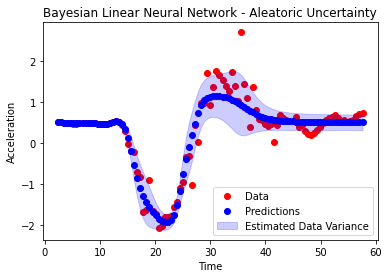

In [10]:
prediction = net_BNN_aleatoric(x_test)
mean = prediction.loc.squeeze().detach().numpy()
std = prediction.scale.squeeze().detach().numpy()

mse = mse_loss(prediction.loc.squeeze(), y_test.squeeze().float())
mae = mae_loss(prediction.loc.squeeze(), y_test.squeeze().float())
kl_divergence = kl_weight * kl_loss(net_BNN_aleatoric)
ELBO = mse + kl_divergence

print('ELBO loss of:' + str(loss.detach().numpy()))
print('kl loss of:' + str((kl_weight*kl).detach().numpy()))
print('MSE loss of:' + str(mse.detach().numpy()))
print('MAE loss of:' + str(mae.detach().numpy()))

plt.figure()
plt.scatter(x_test, y_test, color='r', label='Data')
plt.scatter(x_test, mean, color='b', label='Predictions')
plt.fill_between(x_test.squeeze(), mean - std, mean + std, color='b', alpha=0.2, label='Estimated Data Variance')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend(loc='lower right')
plt.title('Bayesian Linear Neural Network - Aleatoric Uncertainty')
plt.show()

#### Estimate Model Uncertainty

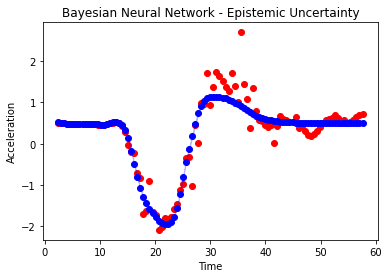

In [11]:
samples = 150
mean = np.zeros((samples, x_test.shape[0]))
std = np.zeros((samples, x_test.shape[0]))

for i in range(samples):
    
    prediction = net_BNN_aleatoric(x_test)
    
    mean[i,:] = prediction.loc.squeeze().detach().numpy()
    std[i,:] = prediction.scale.squeeze().detach().numpy()

mean_ = np.mean(mean, axis = 0)
std_ = np.std(mean, axis = 0)

plt.figure()
plt.scatter(x_test.squeeze(), y_test, color='r', label='Data')
plt.scatter(x_test.squeeze(), mean_, color='b', label='Predictions')
plt.fill_between(x_test.squeeze(), mean_ - std_, mean_ + std_, color='b', alpha = 0.2, label='Model Uncertainties')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Bayesian Neural Network - Epistemic Uncertainty')
plt.show()

### Original BNN - Without Aleatoric Uncertainty

In [12]:
class Net(Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_feature, out_features=n_hidden, bias=True)   # hidden layer
        self.hidden2 = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_hidden, bias=True)
        self.predict = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_output, bias=True)   # output layer
        
    def forward(self, x):
        x = torch.tanh(self.hidden1(x))      # activation function for hidden layer
        x = torch.tanh(self.hidden2(x))
        x = self.predict(x)              # linear output
        
        return x
    
net_BNN = Net(n_feature=1, n_hidden=100, n_output=1)     # define the network
print(net_BNN)  # net architecture

Net(
  (hidden1): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=100, bias=True)
  (hidden2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=100, bias=True)
  (predict): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=1, bias=True)
)


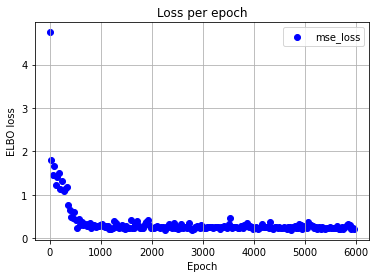

- MSE : 0.30, KL : 3.46
--- 125.48908710479736 seconds ---


In [13]:
start_time = time.time()

net_BNN = net_BNN.float()
n_epochs = 6000 # or whatever
batch_size = 32 # or whatever

train_loader = DataLoader(TensorDataset(x, y), batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(net_BNN.parameters(), lr=0.01)

for epoch in range(n_epochs):
    count = 0
    mse_all = 0
    # Run batch
    for x_train, y_train in train_loader:
        count += 1
    
        optimizer.zero_grad()

        prediction = net_BNN(x_train.float())     # input x and predict based on x

        mse = mse_loss(prediction, y_train.float())

        kl = kl_loss(net_BNN)

        loss = mse + kl_weight*kl

        loss.backward()

        optimizer.step() 
        
        mse_all += mse
        
    if epoch % 30 == 0:
        fig1 = plt.scatter(epoch, mse_all.detach().numpy()/count,color = 'blue') #, label='combined_loss')
        
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('ELBO loss')
plt.grid()
plt.legend(['mse_loss'])
plt.show()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

print("--- %s seconds ---" % (time.time() - start_time))

ELBO loss of: [0.28204167]
kl loss of: [0.03465416]
MSE loss of: 0.24738751
MAE loss of: 0.32800138


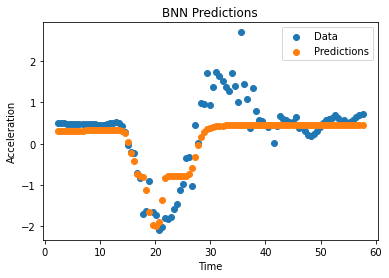

In [14]:
# find losses on test data and show predictions
y_pred = net_BNN(x_test.float()).squeeze().detach().numpy()

pred = net_BNN(x_test.float())
kl = kl_loss(net_BNN)

ELBO = mse_loss(pred.squeeze(), y_test.squeeze().float()) + kl_weight*kl
mse = mse_loss(pred.squeeze(), y_test.squeeze().float())
mae = mae_loss(pred.squeeze(), y_test.squeeze().float())

print('ELBO loss of: ' + str(ELBO.detach().numpy()))
print('kl loss of: ' + str((kl_weight*kl).detach().numpy()))
print('MSE loss of: ' + str(mse.detach().numpy()))
print('MAE loss of: ' + str(mae.detach().numpy()))

plt.figure()
plt.scatter(x_test, y_test, label='Data')
plt.scatter(x_test, y_pred, label='Predictions')
plt.title('BNN Predictions')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend()
plt.show()

## Spectral smoothing

In [15]:
from Modules.BayesLinear import BayesLinear, BLSS

class BayesLinearSpectralSmoothing(Module):
    def __init__(self, rho, n_feature, n_hidden, n_output):
        super(BayesLinearSpectralSmoothing, self).__init__()
        self.hidden1 = BLSS(rho=rho, prior_mu=0, prior_sigma=0.1, in_features=n_feature, out_features=n_hidden, bias=True)   # hidden layer
        self.hidden2 = BLSS(rho=rho, prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_hidden, bias=True)
        self.predict = BLSS(rho=rho, prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_output, bias=True)   # output layer
        
    def forward(self, x):
        x = torch.tanh(self.hidden1(x))
        x = torch.tanh(self.hidden2(x))
        x = self.predict(x)

        return x
    
BSSNN = BayesLinearSpectralSmoothing(rho=0.3, n_feature=1, n_hidden=100, n_output=1)
print(BSSNN)

BayesLinearSpectralSmoothing(
  (hidden1): BLSS(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=100, bias=True)
  (hidden2): BLSS(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=100, bias=True)
  (predict): BLSS(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=1, bias=True)
)


In [16]:
start_time = time.time()

n_epochs = 6000 # or whatever
batch_size = 32 # or whatever

train_loader = DataLoader(TensorDataset(x, y), batch_size=batch_size, shuffle=True)

BSSNN = BSSNN.float()

optimizer = optim.Adam(BSSNN.parameters(),  lr=0.001)

kl_loss = BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01
mse_loss = nn.MSELoss()

for epoch in range(n_epochs):

    # Run batch
    for x_train, y_train in train_loader:
        count += 1
        
        optimizer.zero_grad()

        # in case you wanted a semi-full example
        prediction = BSSNN(x_train)
        kl = kl_loss(BSSNN)
        
        # loss = -distribution.log_prob(y.float()).sum(1).mean() + kl_weight*kl
        loss = mse_loss(prediction.squeeze(), y_train.squeeze().float()) + kl_weight*kl

        mse_all += mse_loss(prediction.squeeze(), y_train.squeeze().float())
        
        loss.backward()
        
        optimizer.step()
        
print("--- %s seconds ---" % (time.time() - start_time))

--- 110.85378527641296 seconds ---


ELBO loss of:[0.12370967]
kl loss of:[0.]
MSE loss of:0.12370967
MAE loss of:0.19967821


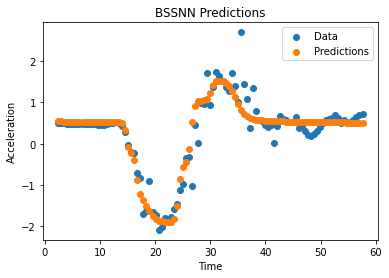

In [17]:
# find losses on test data and show predictions
y_pred = BSSNN(x_test.float()).squeeze().detach().numpy()

pred = BSSNN(x_test.float())
kl = kl_loss(BSSNN)

ELBO = mse_loss(pred.squeeze(), y_test.squeeze().float()) + kl_weight*kl

mse = mse_loss(pred.squeeze(), y_test.squeeze().float())
mae = mae_loss(pred.squeeze(), y_test.squeeze().float())

print('ELBO loss of:' + str(ELBO.detach().numpy()))
print('kl loss of:' + str(kl.detach().numpy()))
print('MSE loss of:' + str(mse.detach().numpy()))
print('MAE loss of:' + str(mae.detach().numpy()))

plt.figure()
plt.scatter(x_test, y_test, label='Data')
plt.scatter(x_test, y_pred, label='Predictions')
plt.title('BSSNN Predictions')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend()
plt.show()

0.1
Total loss of:[0.10215744]
kl loss of:[0.]
MSE loss of:0.102157444
MAE loss of:0.18534152
0.2
Total loss of:[0.0947118]
kl loss of:[0.]
MSE loss of:0.094711795
MAE loss of:0.18291485
0.3
Total loss of:[0.10735887]
kl loss of:[0.]
MSE loss of:0.107358865
MAE loss of:0.18699528
0.4
Total loss of:[0.10348455]
kl loss of:[0.]
MSE loss of:0.10348455
MAE loss of:0.19567128
0.5
Total loss of:[0.07367915]
kl loss of:[0.]
MSE loss of:0.07367915
MAE loss of:0.17520317
0.6
Total loss of:[0.11935934]
kl loss of:[0.]
MSE loss of:0.119359344
MAE loss of:0.21346974
0.7
Total loss of:[0.09192509]
kl loss of:[0.]
MSE loss of:0.09192509
MAE loss of:0.1884355
0.8
Total loss of:[0.08153679]
kl loss of:[0.]
MSE loss of:0.08153679
MAE loss of:0.19659002
0.9
Total loss of:[0.11350404]
kl loss of:[0.]
MSE loss of:0.113504045
MAE loss of:0.18661505


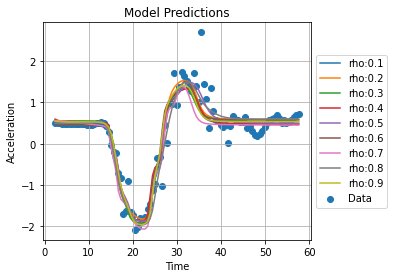

In [18]:
# test rho values
n_epochs = 6000 # or whatever
batch_size = 32 # or whatever
plt.figure()
ax = plt.subplot(111)
mses_all = []
kl_all = []
loss_all = []
mae_all = []

for rho in np.arange(0.1, 1.0, 0.1):
    print(np.round(rho,2))
    from Modules.BayesLinear import BayesLinear, BLSS

    class BayesLinearSpectralSmoothing(Module):
        def __init__(self, rho, n_feature, n_hidden, n_output):
            super(BayesLinearSpectralSmoothing, self).__init__()
            self.hidden1 = BLSS(rho=rho, prior_mu=0, prior_sigma=0.1, in_features=n_feature, out_features=n_hidden, bias=True)   # hidden layer
            self.hidden2 = BLSS(rho=rho, prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_hidden, bias=True)
            self.predict = BLSS(rho=rho, prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_output, bias=True)   # output layer

        def forward(self, x):
            x = torch.tanh(self.hidden1(x))
            x = torch.tanh(self.hidden2(x))
            x = self.predict(x)

            return x

    BSSNN = BayesLinearSpectralSmoothing(rho=0.1, n_feature=1, n_hidden=100, n_output=1)



    train_loader = DataLoader(TensorDataset(x, y), batch_size=batch_size, shuffle=True)

    BSSNN = BSSNN.float()

    optimizer = optim.Adam(BSSNN.parameters(),  lr=0.001)

    kl_loss = BKLLoss(reduction='mean', last_layer_only=False)
    kl_weight = 0.01
    mse_loss = nn.MSELoss()

    for epoch in range(n_epochs):

        # Run batch
        mse_all = 0
        count = 0
        for x_train, y_train in train_loader:
            count += 1

            optimizer.zero_grad()

            # in case you wanted a semi-full example
            prediction = BSSNN(x_train)
            kl = kl_loss(BSSNN)

            # loss = -distribution.log_prob(y.float()).sum(1).mean() + kl_weight*kl
            loss = mse_loss(prediction.squeeze(), y_train.squeeze().float()) + kl_weight*kl

            mse_all += mse_loss(prediction.squeeze(), y_train.squeeze().float())

            loss.backward()

            optimizer.step()
    
    # y-predictions for each rho value
    y_pred = BSSNN(x_test.float()).squeeze().detach().numpy()

    pred = BSSNN(x_test.float())
    kl = kl_loss(BSSNN)

    loss = mse_loss(pred.squeeze(), y_test.squeeze().float()) + kl_weight*kl

    mse = mse_loss(pred.squeeze(), y_test.squeeze().float())
    mae = mae_loss(pred.squeeze(), y_test.squeeze().float())
    
    print('Total loss of:' + str(loss.detach().numpy()))
    print('kl loss of:' + str(kl_weight*kl.detach().numpy()))
    print('MSE loss of:' + str(mse.detach().numpy()))
    print('MAE loss of:' + str(mae.detach().numpy()))
    mses_all.append(mse.detach().numpy())
    loss_all.append(loss.detach().numpy())
    kl_all.append(kl_weight*kl.detach().numpy())
    mae_all.append(mae.detach().numpy())


    plt.plot(x_test, y_pred, label='rho:' + str(np.round(rho,2)))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.title('Model Predictions')
plt.scatter(x_test, y_test, label='Data')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Acceleration')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

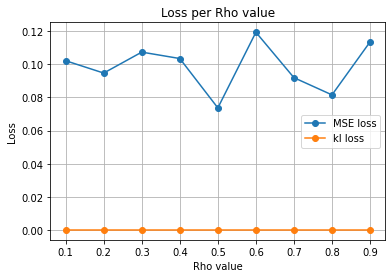

In [19]:
rho_vals = np.arange(0.1, 1.0, 0.1)
plt.figure()
plt.plot(rho_vals, mses_all, '-o', label='MSE loss')
# plt.plot(rho_vals, loss_all, '-o')
plt.plot(rho_vals, kl_all, '-o', label='kl loss')
plt.xlabel('Rho value')
plt.ylabel('Loss')
plt.title('Loss per Rho value')
plt.legend()
plt.grid()
plt.show()

# Laplace

In [20]:
from laplace import Laplace

start_time = time.time()

n_epochs = 6000
batch_size = 32

train_loader = DataLoader(TensorDataset(x, y), batch_size=batch_size, shuffle=True)

n_feature = 1
n_hidden = 100
n_output = 1

model = torch.nn.Sequential(nn.Linear(in_features=n_feature, out_features=n_hidden, bias=True),
                            torch.nn.ReLU(),
                            nn.Linear(in_features=n_hidden, out_features=n_hidden, bias=True),
                            torch.nn.ReLU(),
                            nn.Linear(in_features=n_hidden, out_features=n_output, bias=True))

mse_loss = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(),  lr=0.001)
for i in range(n_epochs):
    # Run batch
    for x_train, y_train in train_loader:
        optimizer.zero_grad()
        prediction = model(x_train.float())     # input x and predict based on x
        mse = mse_loss(prediction.squeeze(), y_train.squeeze().float())
        mse.backward()
        optimizer.step()


# User-specified LA flavor
la = Laplace(model, 'regression',
             subset_of_weights='all',
             hessian_structure='full')


la.fit(train_loader)

log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)

hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)

n_epochs = 10
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 335.8103060722351 seconds ---


MSE loss of:1.5707197
MAE loss of:0.87528694


/Users/oliverdurfeldtpedros/Documents/PythonEnv/DeepLearning/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([101])) that is different to the input size (torch.Size([101, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/oliverdurfeldtpedros/Documents/PythonEnv/DeepLearning/lib/python3.8/site-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([101])) that is different to the input size (torch.Size([101, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


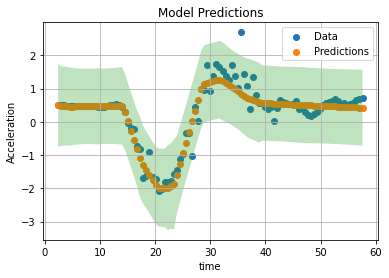

MSE loss of:0.09904193
MAE loss of:0.18771045


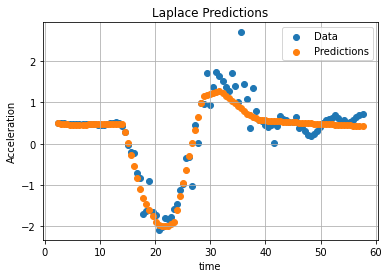

In [21]:
f_mu, f_var = la(x_test)
mse = mse_loss(f_mu, y_test.squeeze().float())
mae = mae_loss(f_mu, y_test.squeeze().float())
f_mu = f_mu.squeeze().detach().numpy()
f_sigma = f_var.squeeze().sqrt().numpy()

pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

print('MSE loss of:' + str(mse.detach().numpy()))
print('MAE loss of:' + str(mae.detach().numpy()))

plt.figure()
plt.scatter(x_test, y_test, label='Data')
plt.scatter(x_test, f_mu, label='Predictions')
plt.fill_between(x_test.squeeze(), f_mu-pred_std,f_mu+pred_std, alpha=0.3)
plt.title('Model Predictions')
plt.ylabel('Acceleration')
plt.xlabel('time')
plt.grid()
plt.legend()
plt.show()

y_pred = torch.tensor(model(x_test).squeeze().detach().numpy())
mse = mse_loss(y_pred, y_test.squeeze().float())
mae = mae_loss(y_pred, y_test.squeeze().float())

print('MSE loss of:' + str(mse.detach().numpy()))
print('MAE loss of:' + str(mae.detach().numpy()))

plt.figure()
plt.scatter(x_test, y_test, label='Data')
plt.scatter(x_test, y_pred, label='Predictions')
#plt.fill_between(x_test.squeeze(), f_mu-pred_std,f_mu+pred_std, alpha=0.3)
plt.title('Laplace Predictions')
plt.ylabel('Acceleration')
plt.xlabel('time')
plt.grid()
plt.legend()
plt.show()

## Feed-Forward Neural Network

In [41]:
class Net(Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(in_features=n_feature, out_features=n_hidden, bias=True)   # hidden layer
        self.hidden2 = nn.Linear(in_features=n_hidden, out_features=n_hidden, bias=True)
        self.predict = nn.Linear(in_features=n_hidden, out_features=n_output, bias=True)   # output layer
        
    def forward(self, x):
        x = torch.tanh(self.hidden1(x))      # activation function for hidden layer
        x = torch.tanh(self.hidden2(x))
        x = self.predict(x)              # linear output
        
        return x
    
net = Net(n_feature=1, n_hidden=100, n_output=1)     # define the network
print(net)  # net architecture

Net(
  (hidden1): Linear(in_features=1, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
)


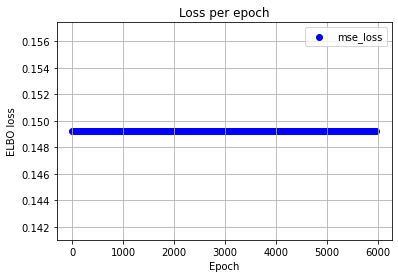

- MSE : 0.17, KL : 0.00
--- 49.33656311035156 seconds ---


In [42]:
start_time = time.time()

net = net.float()
n_epochs = 6000 # or whatever
batch_size = 32 # or whatever

train_loader = DataLoader(TensorDataset(x, y), batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(net.parameters(), lr=0.01)

start_time = time.time()
for epoch in range(n_epochs):
    # Run batch
    count = 0
    for x_train, y_train in train_loader:
        count += 1
    
        optimizer.zero_grad()

        prediction = net(x_train.float())     # input x and predict based on x

        mse = mse_loss(prediction, y_train.float())

        kl = kl_loss(net)

        loss = mse + kl_weight*kl

        loss.backward()

        optimizer.step() 
        
    if epoch % 30 == 0:
        fig1 = plt.scatter(epoch, mse_all.detach().numpy()/count,color = 'blue') #, label='combined_loss')
        
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('ELBO loss')
plt.grid()
plt.legend(['mse_loss'])
plt.show()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

print("--- %s seconds ---" % (time.time() - start_time))

ELBO loss of:[0.40225646]
kl loss of:[0.]
MSE loss of:0.40225646
MAE loss of:0.5093124


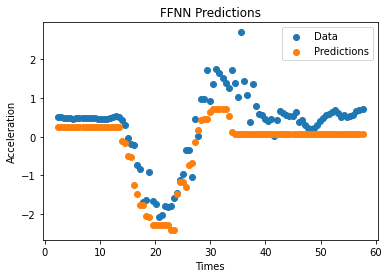

In [43]:
# find losses on test data and show predictions
y_pred = net(x_test.float()).squeeze().detach().numpy()

pred = net(x_test.float())
kl = kl_loss(net)

ELBO = mse_loss(pred.squeeze(), y_test.squeeze().float()) + kl_weight*kl

mse = mse_loss(pred.squeeze(), y_test.squeeze().float())
mae = mae_loss(pred.squeeze(), y_test.squeeze().float())

print('ELBO loss of:' + str(ELBO.detach().numpy()))
print('kl loss of:' + str(kl.detach().numpy()))
print('MSE loss of:' + str(mse.detach().numpy()))
print('MAE loss of:' + str(mae.detach().numpy()))

plt.figure()
plt.scatter(x_test, y_test, label='Data')
plt.scatter(x_test, y_pred, label='Predictions')
plt.title('FFNN Predictions')
plt.xlabel('Times')
plt.ylabel('Acceleration')
plt.legend()
plt.show()

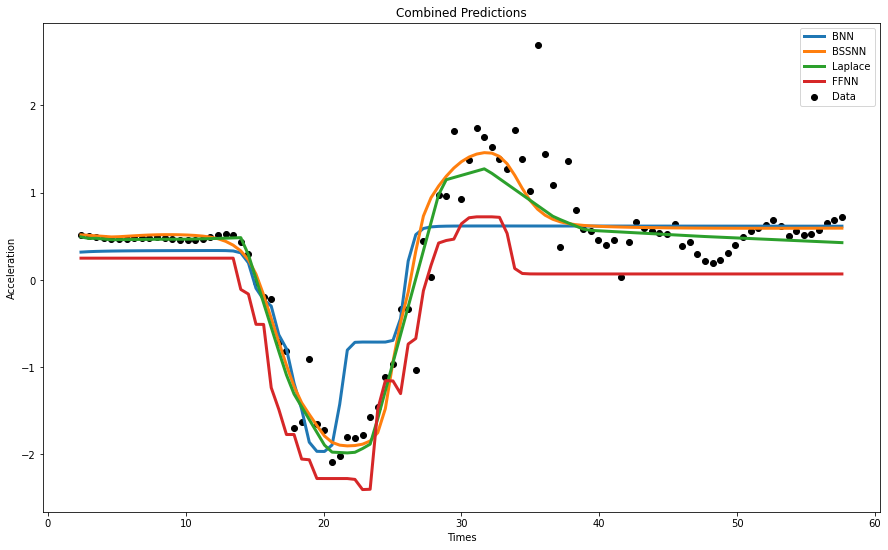

In [44]:
plt.figure(figsize=(15,9))
plt.scatter(x_test, y_test, color='k', label='Data')

pred = net_BNN(x_test.float()).detach().numpy()

plt.plot(x_test, pred, label='BNN', linewidth=3)

pred = BSSNN(x_test.float()).detach().numpy()

plt.plot(x_test, pred, label='BSSNN', linewidth=3)

pred = model(x_test.float()).detach().numpy()

plt.plot(x_test, pred, label='Laplace', linewidth=3)

pred = net(x_test.float()).detach().numpy()

plt.plot(x_test, pred, label='FFNN', linewidth=3)

plt.title('Combined Predictions')
plt.xlabel('Times')
plt.ylabel('Acceleration')
plt.legend()
plt.show()